In [1]:
dataset_root = "../dataset/"
images_dir = dataset_root + "complete/"
features_dir = dataset_root + 'handcrafted/'

recompute_features = False
classify_images = False

In [2]:
import sys
import cv2 as cv
import matplotlib.pyplot as plt
import os
from tensorflow import keras
import numpy as np
sys.path.append("..")

from keras.applications.efficientnet_v2 import EfficientNetV2B0, preprocess_input
from feature_extraction import build_feature_extractor
from similarity_search.neural_similarity_search import extract_features, filter_images_not_in_same_class
from similarity_search.similarity_search_gui import find_similar_images, load_images_features
from handcrafted_extraction import load_all_features, load_features
import pandas as pd

extracted_features_root = "./extracted_features/"
extracted_features_path = extracted_features_root + 'efficient_net_similarity'
predictions_path = extracted_features_root + 'predictions.pickle'

nn, handcrafted_features = load_images_features(True)

2024-01-11 12:58:59.109285: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 12:58:59.109328: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 12:58:59.154476: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-11 12:58:59.218821: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-11 12:59:00.266297: W tensorflow/compiler/tf2

No color features found


  0%|          | 4/130469 [00:00<02:32, 854.76it/s]

No lbp features found


In [3]:
features_tuned = np.load(extracted_features_root + 'efficient_net_similarity.npy')
features_base = np.load(extracted_features_root + 'efficient_net_not_tuned_similarity.npy')
filenames_tuned = pd.read_csv(extracted_features_root + 'efficient_net_similarity_filenames.csv', header=None).iloc[:, 1].values
filenames_base = pd.read_csv(extracted_features_root + 'efficient_net_not_tuned_similarity_filenames.csv', header=None).iloc[:, 1].values

files = os.listdir(images_dir);

## Similar images

In [20]:
## settings
use_nn = True
use_intersection = False
intersect_with_classes = False
images_to_consider = 1000
base_weight = 0.9

## Query image
(the visualized image is used in the search phase)

1/1 [==============================] - 0s 24ms/step


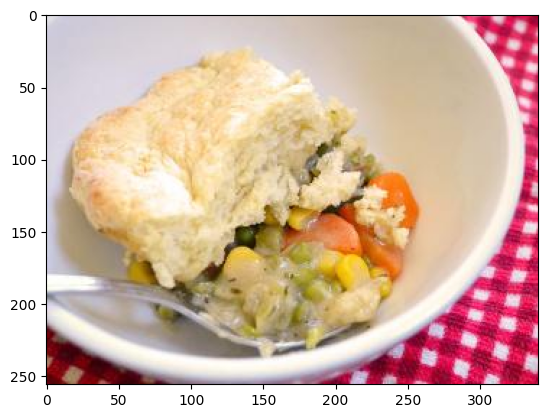

In [21]:
index = 6#np.random.randint(len(files), size=1)[0]
query_path = images_dir + files[index]

query_img = cv.imread(query_path)
query_img = cv.cvtColor(query_img, cv.COLOR_BGR2RGB);

plt.imshow(query_img);
similar_index = 0;
most_similar_filenames = find_similar_images(query_path, handcrafted_features, nn, use_intersection, use_nn, base_weight=base_weight)
most_similar_filenames = ["../" + filename for filename in most_similar_filenames];

## iterate over one image at step

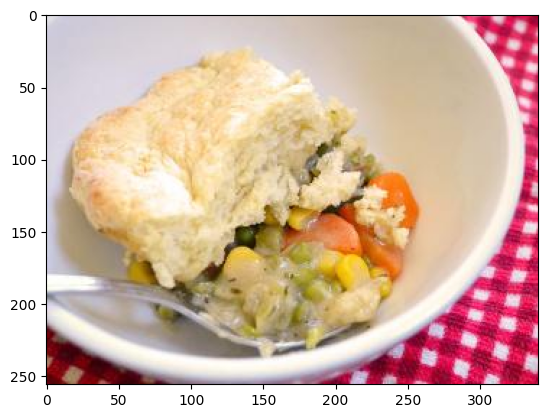

In [14]:
img = cv.imread(most_similar_filenames[similar_index])
img = cv.cvtColor(img, cv.COLOR_BGR2RGB);

plt.imshow(img)
similar_index += 1

## create collage

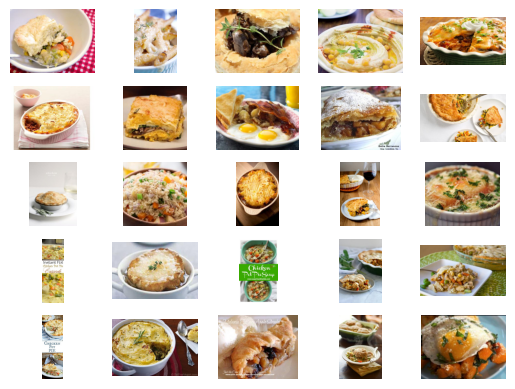

In [22]:
from misc import create_collage_with_random_imgs

create_collage_with_random_imgs("", None, 5, most_similar_filenames, False)